In [1]:
datasets = [
    "blood-transfusion-service-center",  # 748
    "diabetes",  # 768
    "credit-g",  # 1,000 x 20, 13 categorical + 7 numeric
    "car",  # 1,728
    "mfeat-factors",  # 2,000
    "kc1",  # 2,109
    "kr-vs-kp",  # 3,196
    "sylvine",  # 5,124
    "phoneme",  # 5,404
    "jungle_chess_2pcs_raw_endgame_complete",  # 44,819
]

In [2]:
from lale.lib.sklearn import GaussianNB
from lale.lib.sklearn import MultinomialNB
from lale.lib.sklearn import Perceptron
from lale.lib.sklearn import SGDClassifier
from lale.lib.sklearn import PassiveAggressiveClassifier
from lale.lib.sklearn import MLPClassifier
from lale.lib.rasl import BatchedBaggingClassifier
from lale.lib.snapml import BatchedTreeEnsembleClassifier
from lale.lib.lightgbm import LGBMClassifier
from lale.lib.xgboost import XGBClassifier

estimators = [
    GaussianNB(), MultinomialNB(), Perceptron(),
    SGDClassifier(random_state=42),
    PassiveAggressiveClassifier(random_state=42),
    MLPClassifier(random_state=42),
    BatchedBaggingClassifier(), BatchedTreeEnsembleClassifier(),
    LGBMClassifier(), XGBClassifier(),
]

### Dataset

In [3]:
import pandas as pd
import config
import IPython.display
import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

def load_data(dataset_name, test_size):
    (train_X, train_y), (test_X, test_y) = config.get_data(
        dataset_name,
        astype="pandas",
        test_size=test_size,
    )
    return {
        "name": dataset_name,
        "train_X": train_X, "test_X": test_X,
        "train_y": train_y, "test_y": test_y,
    }

In [4]:
TEST_SIZE = 0.1
N_BATCHES = 5
data = load_data("credit-g", TEST_SIZE)

print(f"shapes train_X {data['train_X'].shape}, train_y {data['train_y'].shape}, test_X {data['test_X'].shape}, test_y {data['test_y'].shape}")
with pd.option_context("display.max_rows", 6, "display.max_columns", 8):
    IPython.display.display(pd.concat([data["train_y"], data["train_X"]], axis=1))

shapes train_X (900, 20), train_y (900,), test_X (100, 20), test_y (100,)


,class,checking_status,duration,credit_history,...,job,num_dependents,own_telephone,foreign_worker
633,bad,no checking,9.0,existing paid,...,skilled,1.0,none,yes
215,good,0<=X<200,6.0,critical/other existing credit,...,unskilled resident,1.0,none,yes
982,good,>=200,21.0,existing paid,...,high qualif/self emp/mgmt,1.0,yes,yes
...,...,...,...,...,...,...,...,...,...
901,good,no checking,20.0,critical/other existing credit,...,skilled,1.0,yes,yes
555,bad,0<=X<200,12.0,existing paid,...,skilled,1.0,none,yes
727,bad,<0,18.0,existing paid,...,skilled,1.0,none,yes


In [5]:
from lale.lib.rasl import mockup_data_loader
print([len(bX) for bX, _ in
      mockup_data_loader(data["train_X"], data["train_y"], N_BATCHES, astype="pandas")])

[180, 180, 180, 180, 180]


In [6]:
data["train_y"].value_counts()

good    635
bad     265
Name: class, dtype: int64

In [7]:
from lale.lib.rasl import get_scorer
from lale.lib.rasl import PrioBatch
from lale.lib.rasl import PrioResourceAware
from lale.lib.rasl import fit_with_batches
balanced_accuracy_scorer = get_scorer("balanced_accuracy")

### Training regimes

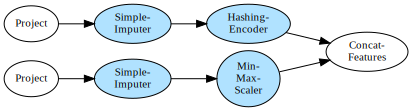

In [8]:
import sklearn.pipeline

prefix_rasl = config.get_prefix_rasl(data["name"], False)
prefix_sklearn = config.get_prefix_sklearn(data["name"], False)
prefix_rasl.visualize()

In [9]:
import statistics
import time
from sklearn.model_selection import train_test_split
import sklearn.base

def evaluate_one(opname, data, trainable_rasl, trainable_sklearn):
    all_X = pd.concat([data["train_X"], data["test_X"]], axis=0)
    all_y = pd.concat([data["train_y"], data["test_y"]], axis=0)
    pt_times, pf_times, ra_times, sk_times = [], [], [], []
    pt_scores, pf_scores, ra_scores, sk_scores = [], [], [], []
    for _ in range(3):
        train_X, test_X, train_y, test_y = train_test_split(
            all_X, all_y, test_size=TEST_SIZE, stratify=all_y)
        start_time = time.time()
        pt_trained = fit_with_batches(
            pipeline=trainable_rasl.clone(),
            batches_train=mockup_data_loader(train_X, train_y, N_BATCHES, astype="pandas"),
            batches_valid=None,
            scoring=None,
            unique_class_labels=all_y.unique(),
            max_resident=None,
            prio=PrioBatch(),
            partial_transform=True,
            verbose=0,
            progress_callback=None,
        )
        pt_times.append(time.time() - start_time)
        pt_scores.append(balanced_accuracy_scorer(pt_trained, test_X, test_y))
        start_time = time.time()
        pf_trained = fit_with_batches(
            pipeline=trainable_rasl.clone(),
            batches_train=mockup_data_loader(train_X, train_y, N_BATCHES, astype="pandas"),
            batches_valid=None,
            scoring=None,
            unique_class_labels=all_y.unique(),
            max_resident=None,
            prio=PrioResourceAware(),
            partial_transform=False,
            verbose=0,
            progress_callback=None,
        )
        pf_times.append(time.time() - start_time)
        pf_scores.append(balanced_accuracy_scorer(pf_trained, test_X, test_y))
        start_time = time.time()
        ra_trained = trainable_rasl.clone().fit(train_X, train_y)
        ra_times.append(time.time() - start_time)
        ra_scores.append(balanced_accuracy_scorer(ra_trained, test_X, test_y))
        start_time = time.time()
        sk_trained = sklearn.base.clone(trainable_sklearn).fit(train_X, train_y)
        sk_times.append(time.time() - start_time)
        sk_scores.append(balanced_accuracy_scorer(sk_trained, test_X, test_y))
    records = [
        {
            "dataset": data["name"],
            "operator": opname,
            "regime": "partial-transform",
            "time_avg": statistics.mean(pt_times),
            "time_std": statistics.stdev(pt_times),
            "score_avg": statistics.mean(pt_scores),
            "score_std": statistics.stdev(pt_scores),
        },
        {
            "dataset": data["name"],
            "operator": opname,
            "regime": "partial-fit",
            "time_avg": statistics.mean(pf_times),
            "time_std": statistics.stdev(pf_times),
            "score_avg": statistics.mean(pf_scores),
            "score_std": statistics.stdev(pf_scores),
        },
        {
            "dataset": data["name"],
            "operator": opname,
            "regime": "non-inc-rasl",
            "time_avg": statistics.mean(ra_times),
            "time_std": statistics.stdev(ra_times),
            "score_avg": statistics.mean(ra_scores),
            "score_std": statistics.stdev(ra_scores),
        },
        {
            "dataset": data["name"],
            "operator": opname,
            "regime": "non-inc-sklearn",
            "time_avg": statistics.mean(sk_times),
            "time_std": statistics.stdev(sk_times),
            "score_avg": statistics.mean(sk_scores),
            "score_std": statistics.stdev(sk_scores),
        },
    ]
    return pd.DataFrame.from_records(records)

In [10]:
import numpy as np

def plot_results(df, yvalues, yerrors, ylabel, yscale):
    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
    ind = np.arange(len(df.operator.unique()))
    width=0.2
    fig, ax = plt.subplots()
    ax.bar(
        ind - 1.5 * width,
        df[df.regime=="partial-transform"][yvalues],
        width,
        yerr=df[df.regime=="partial-transform"][yerrors],
        capsize=3,
        label="partial-transform"
    )
    ax.bar(
        ind - 0.5 * width,
        df[df.regime=="partial-fit"][yvalues],
        width,
        yerr=df[df.regime=="partial-fit"][yerrors],
        capsize=3,
        label="partial-fit"
    )
    ax.bar(
        ind + 0.5 * width,
        df[df.regime=="non-inc-rasl"][yvalues],
        width,
        yerr=df[df.regime=="non-inc-rasl"][yerrors],
        capsize=3,
        label="non-inc-rasl"
    )
    ax.bar(
        ind + 1.5 * width,
        df[df.regime=="non-inc-sklearn"][yvalues],
        width,
        yerr=df[df.regime=="non-inc-sklearn"][yerrors],
        capsize=3,
        label="non-inc-sklearn"
    )
    ax.set_ylabel(ylabel)
    ax.set_yscale(yscale)
    ax.set_xticks(ind)
    ax.set_xticklabels(tuple(df.operator.unique()), rotation=90)
    ax.legend()
    plt.show()

In [11]:
def shorten_operator_name(operator_name):
    if operator_name.endswith("Classifier"):
        return operator_name[:-len("Classifier")]
    return operator_name

def summarize_results(df, yvalues, group_by):
    pivoted = pd.DataFrame.from_records([
        {
            "dataset": dataset,
            "operator": shorten_operator_name(operator),
            "partial-transform":
                df[(df["operator"]==operator) & (df["dataset"]==dataset)
                   & (df["regime"]=="partial-transform")][yvalues].iloc[0],
            "partial-fit":
                df[(df["operator"]==operator) & (df["dataset"]==dataset)
                   & (df["regime"]=="partial-fit")][yvalues].iloc[0],
            "non-inc-rasl":
                df[(df["operator"]==operator) & (df["dataset"]==dataset)
                   & (df["regime"]=="non-inc-rasl")][yvalues].iloc[0],
            "non-inc-sklearn":
                df[(df["operator"]==operator) & (df["dataset"]==dataset)
                   & (df["regime"]=="non-inc-sklearn")][yvalues].iloc[0],
        }
        for dataset in df["dataset"].unique()
        for operator in df["operator"].unique()
    ])
    normalized = pd.DataFrame({
        "dataset": pivoted["dataset"],
        "operator": pivoted["operator"],
        "partial-transform": pivoted["partial-transform"] / pivoted["non-inc-sklearn"],
        "partial-fit": pivoted["partial-fit"] / pivoted["non-inc-sklearn"],
        "non-inc-rasl": pivoted["non-inc-rasl"] / pivoted["non-inc-sklearn"],
        "non-inc-sklearn": pivoted["non-inc-sklearn"] / pivoted["non-inc-sklearn"],
    })
    group_avg = normalized.groupby(group_by).agg("mean")
    group_std = normalized.groupby(group_by).agg("std")
    grouped = pd.DataFrame({
        "partial-transform": group_avg["partial-transform"],
        "partial-transform-std": group_std["partial-transform"],
        "partial-fit": group_avg["partial-fit"],
        "partial-fit-std": group_std["partial-fit"],
        "non-inc-rasl": group_avg["non-inc-rasl"],
        "non-inc-rasl-std": group_std["non-inc-rasl"],        
        "non-inc-sklearn": group_avg["non-inc-sklearn"],
        "non-inc-sklearn-std": group_std["non-inc-sklearn"],        
    })
    gsorted = grouped.sort_values("partial-transform")
    result = pd.concat([gsorted, gsorted.agg(["mean", "std"])])
    return result

In [12]:
dataframes_creditg = []
for est in estimators:
    print(f"evaluating dataset {data['name']}, estimator {est.name()} ...")
    df = evaluate_one(est.name(), data, prefix_rasl >> est,
                      sklearn.pipeline.make_pipeline(prefix_sklearn, est))
    dataframes_creditg.append(df)

evaluating dataset credit-g, estimator GaussianNB ...
evaluating dataset credit-g, estimator MultinomialNB ...
evaluating dataset credit-g, estimator Perceptron ...
evaluating dataset credit-g, estimator SGDClassifier ...
evaluating dataset credit-g, estimator PassiveAggressiveClassifier ...
evaluating dataset credit-g, estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8ve

evaluating dataset credit-g, estimator BatchedBaggingClassifier ...
evaluating dataset credit-g, estimator BatchedTreeEnsembleClassifier ...
evaluating dataset credit-g, estimator LGBMClassifier ...
evaluating dataset credit-g, estimator XGBClassifier ...


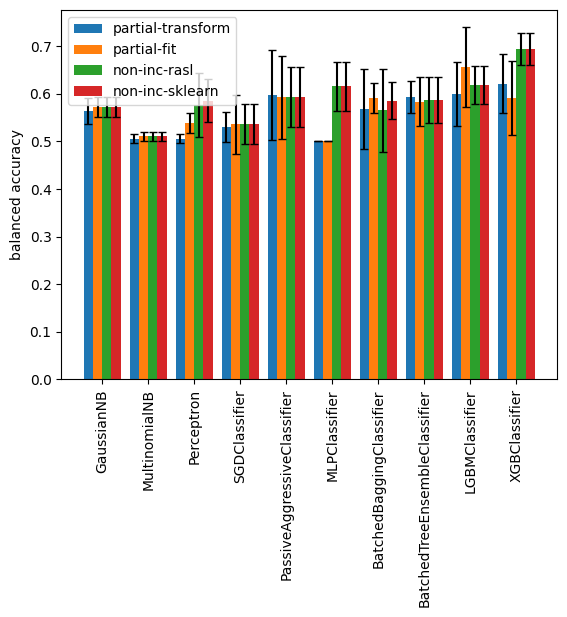

,partial-transform,partial-transform-std,partial-fit,partial-fit-std,non-inc-rasl,non-inc-rasl-std,non-inc-sklearn,non-inc-sklearn-std
MLP,0.812,NaN,0.812,NaN,1.000,NaN,1.0,NaN
Perceptron,0.863,NaN,0.920,NaN,0.984,NaN,1.0,NaN
XGB,0.895,NaN,0.850,NaN,1.000,NaN,1.0,NaN
BatchedBagging,0.969,NaN,1.008,NaN,0.965,NaN,1.0,NaN
LGBM,0.969,NaN,1.059,NaN,1.000,NaN,1.0,NaN
GaussianNB,0.985,NaN,1.000,NaN,1.000,NaN,1.0,NaN
SGD,0.988,NaN,0.999,NaN,1.000,NaN,1.0,NaN
MultinomialNB,0.989,NaN,1.000,NaN,1.000,NaN,1.0,NaN
PassiveAggressive,1.008,NaN,1.000,NaN,1.000,NaN,1.0,NaN
BatchedTreeEnsemble,1.012,NaN,0.995,NaN,1.000,NaN,1.0,NaN


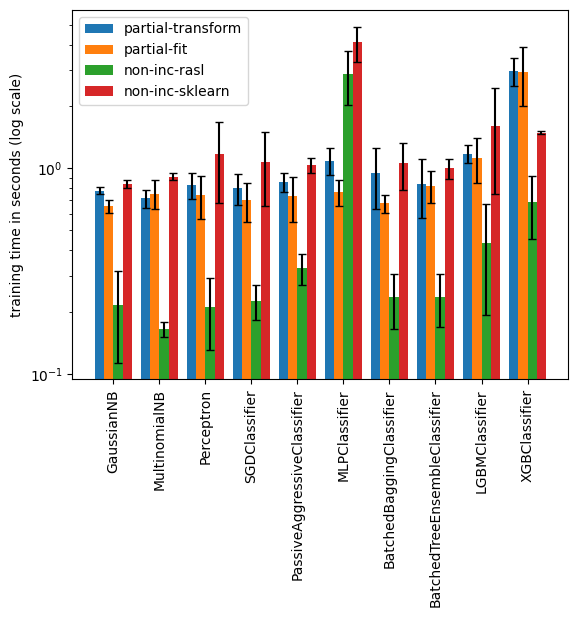

,partial-transform,partial-transform-std,partial-fit,partial-fit-std,non-inc-rasl,non-inc-rasl-std,non-inc-sklearn,non-inc-sklearn-std
MLP,0.265,NaN,0.187,NaN,0.702,NaN,1.0,NaN
Perceptron,0.703,NaN,0.629,NaN,0.180,NaN,1.0,NaN
LGBM,0.729,NaN,0.698,NaN,0.267,NaN,1.0,NaN
SGD,0.745,NaN,0.650,NaN,0.210,NaN,1.0,NaN
MultinomialNB,0.786,NaN,0.828,NaN,0.182,NaN,1.0,NaN
PassiveAggressive,0.829,NaN,0.705,NaN,0.317,NaN,1.0,NaN
BatchedTreeEnsemble,0.842,NaN,0.824,NaN,0.237,NaN,1.0,NaN
BatchedBagging,0.893,NaN,0.637,NaN,0.222,NaN,1.0,NaN
GaussianNB,0.923,NaN,0.777,NaN,0.255,NaN,1.0,NaN
XGB,1.995,NaN,1.978,NaN,0.459,NaN,1.0,NaN


In [13]:
df_creditg = pd.concat(dataframes_creditg, axis=0)
plot_results(df_creditg, "score_avg", "score_std", "balanced accuracy", "linear")
IPython.display.display(summarize_results(df_creditg, "score_avg", "operator"))
plot_results(df_creditg, "time_avg", "time_std", "training time in seconds (log scale)", "log")
IPython.display.display(summarize_results(df_creditg, "time_avg", "operator"))

### Across several datasets

In [14]:
dataframes_all = []
for dataset_name in datasets:
    data = load_data(dataset_name, TEST_SIZE)
    prefix_rasl = config.get_prefix_rasl(dataset_name, False)
    prefix_sklearn = config.get_prefix_sklearn(dataset_name, False)
    print(f"dataset {dataset_name}")
    for est in estimators:
        print(f"  evaluating estimator {est.name()} ...")
        df = evaluate_one(est.name(), data, prefix_rasl >> est(),
                          sklearn.pipeline.make_pipeline(prefix_sklearn, est()))
        dataframes_all.append(df)

dataset blood-transfusion-service-center
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...
dataset diabetes
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8ve

  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...
dataset credit-g
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8ve

  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...
dataset car
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...
dataset mfeat-factors
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8ve

  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...
dataset kc1
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8ve

  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...
dataset kr-vs-kp
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...
  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...
dataset sylvine
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8ve

  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...
dataset phoneme
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8ve

  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...
dataset jungle_chess_2pcs_raw_endgame_complete
  evaluating estimator GaussianNB ...
  evaluating estimator MultinomialNB ...
  evaluating estimator Perceptron ...
  evaluating estimator SGDClassifier ...
  evaluating estimator PassiveAggressiveClassifier ...
  evaluating estimator MLPClassifier ...


/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hirzel/python3.8ve

  evaluating estimator BatchedBaggingClassifier ...
  evaluating estimator BatchedTreeEnsembleClassifier ...
  evaluating estimator LGBMClassifier ...
  evaluating estimator XGBClassifier ...


In [15]:
df_all = pd.concat(dataframes_all)
print(f"score_avg grouped by operator")
IPython.display.display(summarize_results(df_all, "score_avg", "operator"))
print(f"time_avg grouped by operator")
IPython.display.display(summarize_results(df_all, "time_avg", "operator"))
print(f"score_avg grouped by dataset")
IPython.display.display(summarize_results(df_all, "score_avg", "dataset"))
print(f"time_avg grouped by dataset")
IPython.display.display(summarize_results(df_all, "time_avg", "dataset"))

score_avg grouped by operator


,partial-transform,partial-transform-std,partial-fit,partial-fit-std,non-inc-rasl,non-inc-rasl-std,non-inc-sklearn,non-inc-sklearn-std
MLP,0.733,0.126,0.739,0.137,0.988,0.017,1.0,0.0
LGBM,0.906,0.152,0.910,0.141,1.000,0.002,1.0,0.0
BatchedTreeEnsemble,0.932,0.056,0.951,0.057,1.004,0.011,1.0,0.0
Perceptron,0.945,0.084,0.960,0.113,1.005,0.096,1.0,0.0
SGD,0.969,0.072,0.978,0.083,1.021,0.085,1.0,0.0
PassiveAggressive,0.987,0.109,0.958,0.096,0.990,0.110,1.0,0.0
GaussianNB,0.989,0.018,1.000,0.000,1.000,0.000,1.0,0.0
MultinomialNB,0.998,0.004,1.000,0.000,1.000,0.000,1.0,0.0
XGB,0.998,0.102,1.001,0.100,0.995,0.015,1.0,0.0
BatchedBagging,1.015,0.047,1.023,0.048,0.994,0.021,1.0,0.0


time_avg grouped by operator


,partial-transform,partial-transform-std,partial-fit,partial-fit-std,non-inc-rasl,non-inc-rasl-std,non-inc-sklearn,non-inc-sklearn-std
MLP,0.179,0.273,0.167,0.273,0.913,0.278,1.0,0.0
PassiveAggressive,1.311,1.267,1.160,1.160,1.000,0.457,1.0,0.0
XGB,2.434,1.114,2.327,0.987,0.783,0.259,1.0,0.0
BatchedTreeEnsemble,3.806,3.920,3.167,3.186,1.271,0.832,1.0,0.0
LGBM,3.855,2.995,3.769,3.080,0.926,0.414,1.0,0.0
SGD,9.243,8.243,8.090,7.443,2.485,1.821,1.0,0.0
Perceptron,10.159,9.989,9.583,9.103,2.559,1.916,1.0,0.0
MultinomialNB,14.169,14.223,12.110,13.575,3.073,3.248,1.0,0.0
BatchedBagging,15.834,22.763,13.415,22.207,3.632,5.380,1.0,0.0
GaussianNB,20.567,27.135,18.140,24.430,3.858,4.516,1.0,0.0


score_avg grouped by dataset


,partial-transform,partial-transform-std,partial-fit,partial-fit-std,non-inc-rasl,non-inc-rasl-std,non-inc-sklearn,non-inc-sklearn-std
mfeat-factors,0.876,0.194,0.885,0.193,1.001,0.008,1.0,0.0
kc1,0.926,0.069,0.952,0.078,0.987,0.030,1.0,0.0
phoneme,0.943,0.133,0.961,0.139,1.042,0.079,1.0,0.0
jungle_chess_2pcs_raw_endgame_complete,0.949,0.144,0.963,0.141,0.982,0.039,1.0,0.0
diabetes,0.950,0.109,0.961,0.103,1.014,0.047,1.0,0.0
sylvine,0.952,0.120,0.924,0.107,1.008,0.057,1.0,0.0
credit-g,0.957,0.082,0.923,0.070,0.973,0.057,1.0,0.0
kr-vs-kp,0.957,0.070,0.975,0.070,1.018,0.038,1.0,0.0
blood-transfusion-service-center,0.976,0.082,0.988,0.103,0.995,0.067,1.0,0.0
car,0.989,0.113,0.988,0.118,0.977,0.049,1.0,0.0


time_avg grouped by dataset


,partial-transform,partial-transform-std,partial-fit,partial-fit-std,non-inc-rasl,non-inc-rasl-std,non-inc-sklearn,non-inc-sklearn-std
car,0.593,0.610,0.542,0.579,0.225,0.156,1.0,0.0
credit-g,1.012,0.379,0.896,0.372,0.358,0.185,1.0,0.0
kr-vs-kp,1.230,0.240,1.165,0.280,0.629,0.188,1.0,0.0
jungle_chess_2pcs_raw_endgame_complete,1.923,1.817,1.746,1.778,1.249,0.303,1.0,0.0
phoneme,6.366,4.182,5.813,4.035,2.001,1.243,1.0,0.0
blood-transfusion-service-center,9.515,6.249,7.698,4.841,1.933,0.870,1.0,0.0
sylvine,9.980,8.897,8.241,7.950,2.562,1.482,1.0,0.0
diabetes,11.681,8.592,9.229,6.554,2.438,1.470,1.0,0.0
kc1,15.552,14.304,14.202,12.185,3.595,2.448,1.0,0.0
mfeat-factors,23.703,33.881,22.394,31.833,5.513,6.599,1.0,0.0


In [16]:
def plot_summarized_results_horizontal(df):
    df_ops_only = df[:-1]
    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
    ind = np.flip(np.arange(df_ops_only.shape[0]))
    height=0.2
    fig, ax = plt.subplots()
    ax.barh(
        y=ind + 1.5 * height,
        width=df_ops_only["non-inc-sklearn"],
        height=height,
        label="non-inc-sklearn"
    )
    ax.barh(
        y=ind + 0.5 * height,
        width=df_ops_only["non-inc-rasl"],
        height=height,
        label="non-inc-rasl"
    )
    ax.barh(
        y=ind - 0.5 * height,
        width=df_ops_only["partial-fit"],
        height=height,
        label="partial-fit"
    )
    ax.barh(
        y=ind - 1.5 * height,
        width=df_ops_only["partial-transform"],
        height=height,
        label="partial-transform"
    )
    ax.set_xlim(0.5, 1.09)
    ax.set_xlabel("balanced accuracy, normalized to noninc-sklearn")
    ax.set_ylabel("operator")
    ax.set_yticks(ind)
    ax.set_yticklabels(df_ops_only.index)
    ax.legend(loc="center left")
    plt.show()

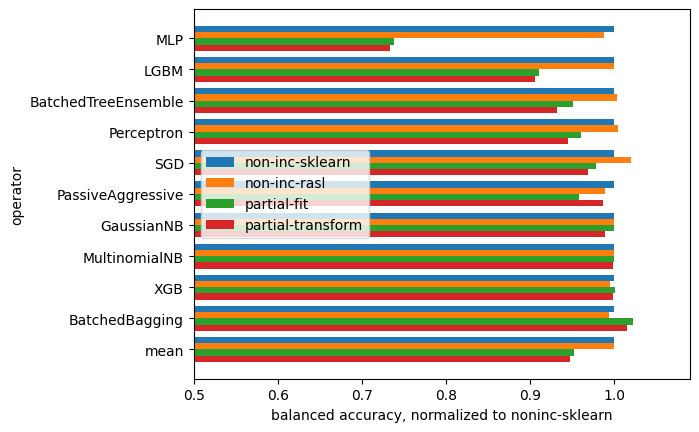

In [17]:
plot_summarized_results_horizontal(summarize_results(df_all, "score_avg", "operator"))

In [18]:
def plot_summarized_results_vertical(df):
    df_ops_only = df[:-1]
    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
    ind = np.arange(df_ops_only.shape[0])
    width = 0.2
    fig, ax = plt.subplots()
    ax.bar(
        x=ind - 1.5 * width,
        height=df_ops_only["non-inc-sklearn"],
        width=width,
        label="non-inc-sklearn"
    )
    ax.bar(
        x=ind - 0.5 * width,
        height=df_ops_only["non-inc-rasl"],
        width=width,
        label="non-inc-rasl"
    )
    ax.bar(
        x=ind + 0.5 * width,
        height=df_ops_only["partial-fit"],
        width=width,
        label="partial-fit"
    )
    ax.bar(
        x=ind + 1.5 * width,
        height=df_ops_only["partial-transform"],
        width=width,
        label="partial-transform"
    )
    ax.set_ylim(0.5, 1.09)
    ax.set_ylabel("balanced accuracy, normalized to noninc-sklearn")
    ax.set_xlabel("operator")
    ax.set_xticks(ind)
    ax.set_xticklabels(df_ops_only.index, rotation=75)
    ax.legend(loc="lower center")
    plt.show()

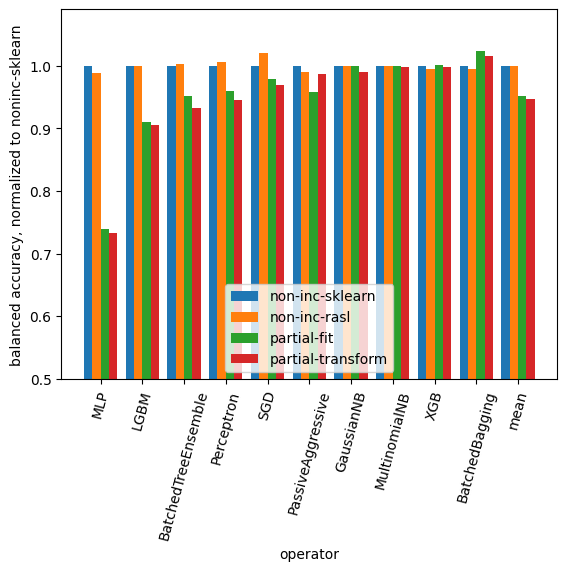

In [19]:
plot_summarized_results_vertical(summarize_results(df_all, "score_avg", "operator"))

### Another dataset

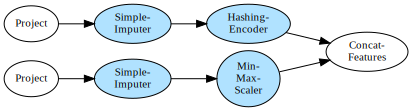

In [20]:
data = load_data("adult", TEST_SIZE)
prefix_rasl = config.get_prefix_rasl(data["name"], False)
prefix_sklearn = config.get_prefix_sklearn(data["name"], False)
prefix_rasl.visualize()

In [21]:
dataframes_adult = []
for est in estimators:
    print(f"evaluating dataset {data['name']}, estimator {est.name()} ...")
    df = evaluate_one(est.name(), data, prefix_rasl >> est(),
                      sklearn.pipeline.make_pipeline(prefix_sklearn, est()))
    dataframes_adult.append(df)
df_adult = pd.concat(dataframes_adult, axis=0)

evaluating dataset adult, estimator GaussianNB ...
evaluating dataset adult, estimator MultinomialNB ...
evaluating dataset adult, estimator Perceptron ...
evaluating dataset adult, estimator SGDClassifier ...
evaluating dataset adult, estimator PassiveAggressiveClassifier ...
evaluating dataset adult, estimator MLPClassifier ...
evaluating dataset adult, estimator BatchedBaggingClassifier ...
evaluating dataset adult, estimator BatchedTreeEnsembleClassifier ...
evaluating dataset adult, estimator LGBMClassifier ...
evaluating dataset adult, estimator XGBClassifier ...


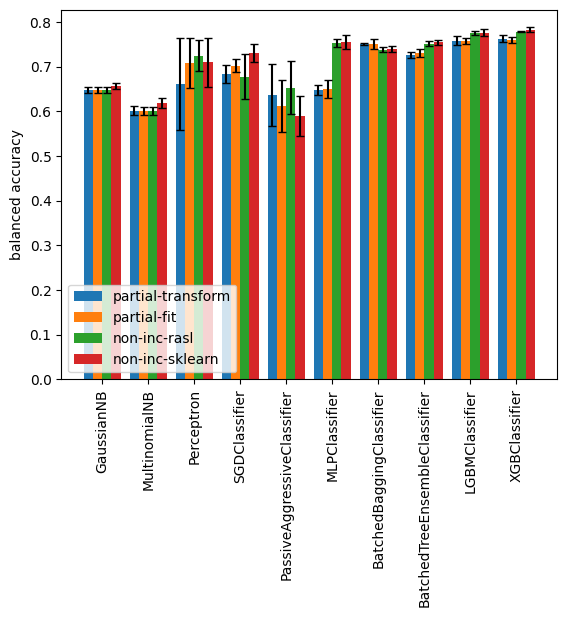

,partial-transform,partial-transform-std,partial-fit,partial-fit-std,non-inc-rasl,non-inc-rasl-std,non-inc-sklearn,non-inc-sklearn-std
MLP,0.857,NaN,0.861,NaN,0.997,NaN,1.0,NaN
Perceptron,0.931,NaN,0.998,NaN,1.021,NaN,1.0,NaN
SGD,0.936,NaN,0.961,NaN,0.927,NaN,1.0,NaN
BatchedTreeEnsemble,0.963,NaN,0.968,NaN,0.996,NaN,1.0,NaN
MultinomialNB,0.973,NaN,0.973,NaN,0.973,NaN,1.0,NaN
XGB,0.975,NaN,0.971,NaN,0.995,NaN,1.0,NaN
LGBM,0.978,NaN,0.977,NaN,0.999,NaN,1.0,NaN
GaussianNB,0.988,NaN,0.987,NaN,0.987,NaN,1.0,NaN
BatchedBagging,1.015,NaN,1.015,NaN,0.999,NaN,1.0,NaN
PassiveAggressive,1.080,NaN,1.039,NaN,1.109,NaN,1.0,NaN


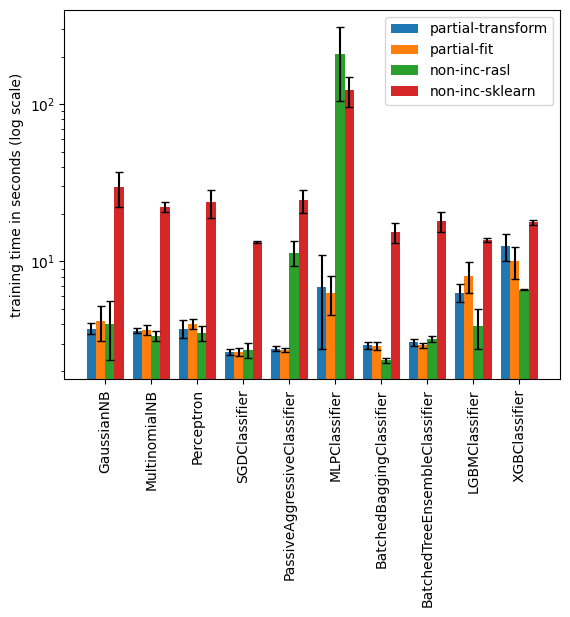

,partial-transform,partial-transform-std,partial-fit,partial-fit-std,non-inc-rasl,non-inc-rasl-std,non-inc-sklearn,non-inc-sklearn-std
MLP,0.056,NaN,0.051,NaN,1.700,NaN,1.0,NaN
PassiveAggressive,0.114,NaN,0.112,NaN,0.465,NaN,1.0,NaN
GaussianNB,0.126,NaN,0.141,NaN,0.135,NaN,1.0,NaN
Perceptron,0.157,NaN,0.167,NaN,0.147,NaN,1.0,NaN
MultinomialNB,0.163,NaN,0.166,NaN,0.151,NaN,1.0,NaN
BatchedTreeEnsemble,0.170,NaN,0.163,NaN,0.178,NaN,1.0,NaN
BatchedBagging,0.192,NaN,0.189,NaN,0.154,NaN,1.0,NaN
SGD,0.200,NaN,0.201,NaN,0.205,NaN,1.0,NaN
LGBM,0.461,NaN,0.590,NaN,0.283,NaN,1.0,NaN
XGB,0.702,NaN,0.563,NaN,0.370,NaN,1.0,NaN


In [22]:
plot_results(df_adult, "score_avg", "score_std", "balanced accuracy", "linear")
IPython.display.display(summarize_results(df_adult, "score_avg", "operator"))
plot_results(df_adult, "time_avg", "time_std", "training time in seconds (log scale)", "log")
IPython.display.display(summarize_results(df_adult, "time_avg", "operator"))

### Learning curves with partial_transform

In [23]:
class LearningCurveCallback:
    def __init__(self):
        self.scores_train = []
        self.scores_valid = []

    def __call__(self, score_train, score_valid, n_batches_scanned, end_of_scanned_batches):
        self.scores_train.append(score_train)
        self.scores_valid.append(score_valid)
        fig, ax = plt.subplots()
        ax.set_ylim([0, 1.1])
        ax.plot(range(n_batches_scanned), self.scores_train, label="train")
        ax.plot(range(n_batches_scanned), self.scores_valid, label="valid")
        ax.legend()
        IPython.display.clear_output()
        plt.show()
        assert len(self.scores_train) == n_batches_scanned + (1 if end_of_scanned_batches else 0)
        assert len(self.scores_valid) == len(self.scores_train)

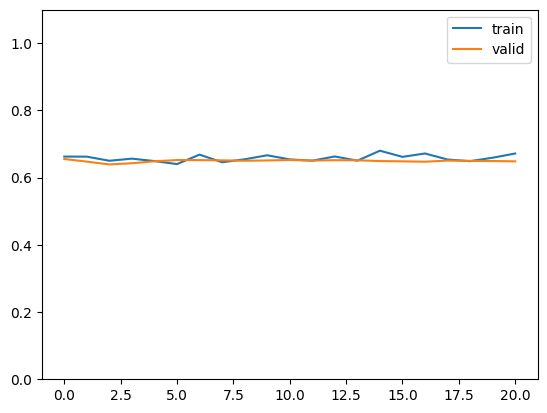

CPU times: user 16.5 s, sys: 4.3 s, total: 20.9 s
Wall time: 15.8 s


In [24]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> GaussianNB(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)

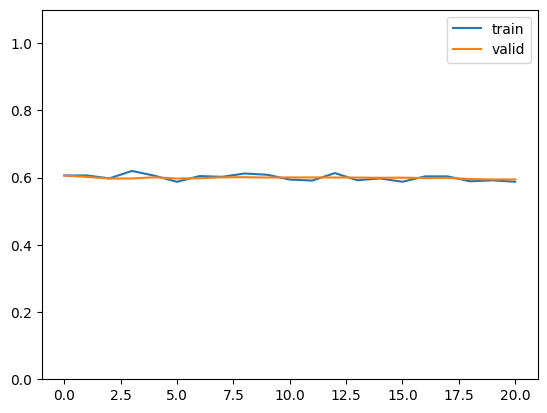

CPU times: user 17.2 s, sys: 4.12 s, total: 21.3 s
Wall time: 16.2 s


In [25]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> MultinomialNB(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)

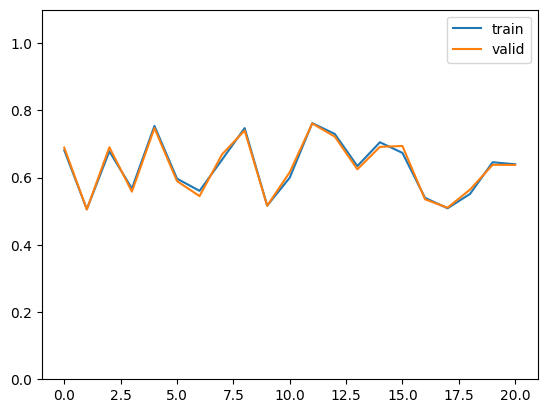

CPU times: user 24.5 s, sys: 29.4 s, total: 53.9 s
Wall time: 16.9 s


In [26]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> Perceptron(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)

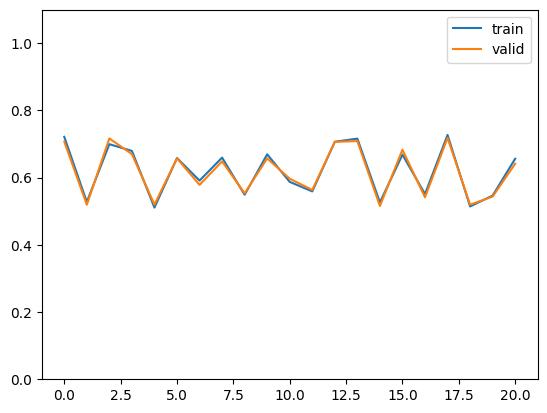

CPU times: user 29.3 s, sys: 30 s, total: 59.3 s
Wall time: 21.7 s


In [27]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> SGDClassifier(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)

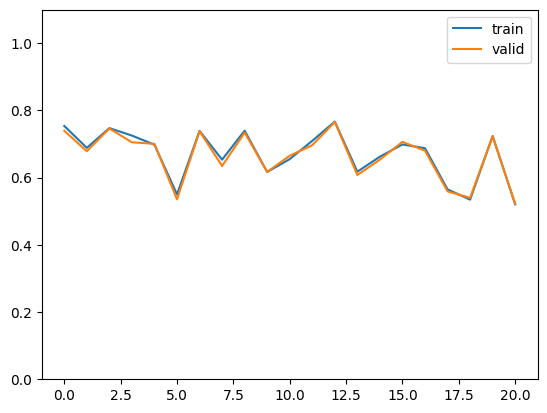

CPU times: user 25.3 s, sys: 29.1 s, total: 54.3 s
Wall time: 17.4 s


In [28]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> PassiveAggressiveClassifier(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)

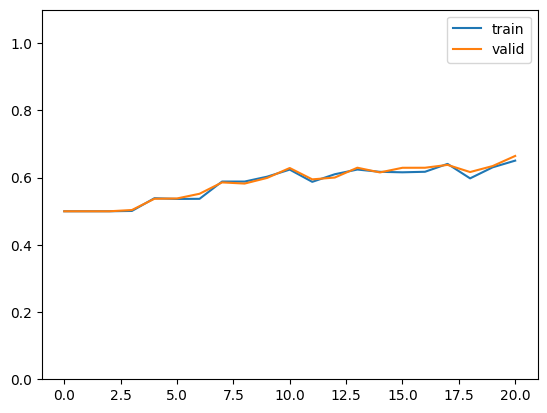

CPU times: user 29 s, sys: 44.6 s, total: 1min 13s
Wall time: 19.7 s


In [29]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> MLPClassifier(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)

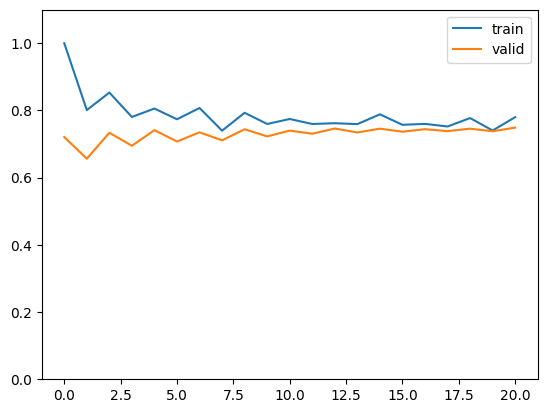

CPU times: user 1min 11s, sys: 4.75 s, total: 1min 15s
Wall time: 1min 9s


In [30]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> BatchedBaggingClassifier(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)

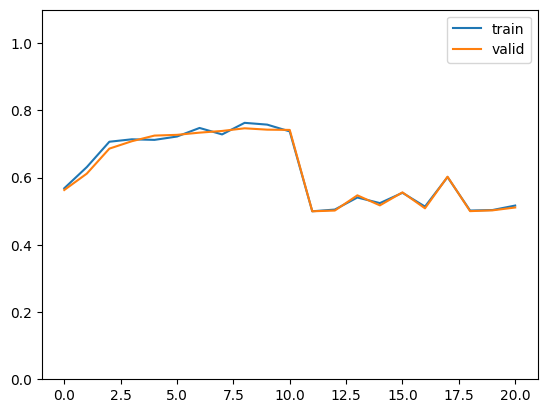

CPU times: user 17.2 s, sys: 4.22 s, total: 21.4 s
Wall time: 16.3 s


In [31]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> BatchedTreeEnsembleClassifier(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)

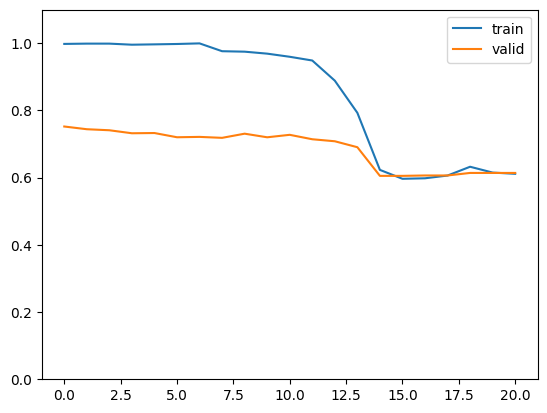

CPU times: user 2min 13s, sys: 3.94 s, total: 2min 17s
Wall time: 2min 12s


In [32]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> LGBMClassifier(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)

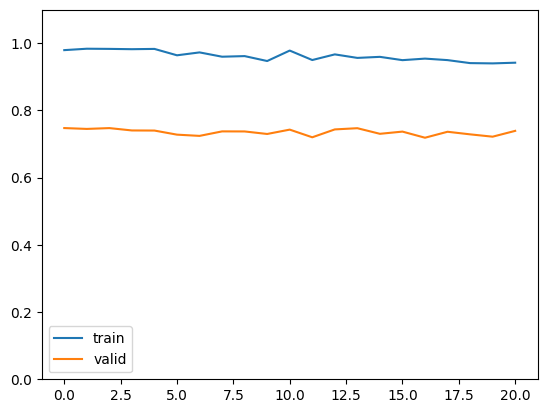

CPU times: user 44 s, sys: 4.14 s, total: 48.1 s
Wall time: 43 s


In [33]:
%%time
trained = fit_with_batches(
    pipeline=prefix_rasl.clone() >> XGBClassifier(),
    batches_train=mockup_data_loader(data["train_X"], data["train_y"], 21, astype="pandas"),
    batches_valid=[(data["test_X"], data["test_y"])],
    scoring=balanced_accuracy_scorer,
    unique_class_labels=data["train_y"].unique(),
    max_resident=None,
    prio=PrioBatch(),
    partial_transform=True,
    verbose=0,
    progress_callback=LearningCurveCallback(),
)